# Collect data from MIRA (SARS-Cov-2)

首先在 https://clients.adaptivebiotech.com/pub/covid-2020 上下载数据，放在 ``TCRdata/raw/database/MIRA/`` 文件夹下。示例：
- ImmuneCODE-MIRA-Release002.1.zip:
    - Focusing on TCR beta chain
    - Two ways to collect data:
        - minigene
        - peptide
    - Main files:
        - minigene-detail.csv
        - peptide-detail-ci.csv
        - peptide-detail-cii.csv

In [1]:
import re
import pandas as pd
from utils import save_csv, plot_non_empty_percentage

to_your_path = '/data/lujd/'

### ¶ prepare data

In [3]:
'''
ImmuneCODE-MIRA-Release002.1:
    - Focusing on TCR beta chain
    - Two ways to collect data:
        - minigene
        - peptide
    - Main files:
        - minigene-detail.csv
        - peptide-detail-ci.csv
        - peptide-detail-cii.csv
'''

datapath = to_your_path + "TCRdata/raw/database/MIRA/ImmuneCODE-MIRA-Release002.1/"

filenames = [   "minigene-detail.csv",
                "peptide-detail-ci.csv",
                "peptide-detail-cii.csv"]

dfs = []
for fn in filenames:
    dfs.append(pd.read_csv(datapath+fn, sep=",", header=0, low_memory=False))

for df in dfs:
    print(f"df size: {len(df)}")
    print("*"*40)
    print(f"{df.count()}")
    print("*"*40)
    print(f"{df.nunique()}")
    print("-"*50)

df size: 1523
****************************************
TCR BioIdentity            1523
TCR Nucleotide Sequence    1523
Experiment                 1523
ORF                        1523
ORF Genebank ID            1523
Amino Acid                 1523
Start Index in Genome      1523
End Index in Genome        1523
dtype: int64
****************************************
TCR BioIdentity            1481
TCR Nucleotide Sequence    1523
Experiment                    4
ORF                           9
ORF Genebank ID               9
Amino Acid                   38
Start Index in Genome        38
End Index in Genome          38
dtype: int64
--------------------------------------------------
df size: 154320
****************************************
TCR BioIdentity            154320
TCR Nucleotide Sequence    154320
Experiment                 154320
ORF Coverage               154320
Amino Acids                154320
Start Index in Genome      154320
End Index in Genome        154320
dtype: int64
*******

In [5]:
dfs[1].head(2)

,TCR BioIdentity,TCR Nucleotide Sequence,Experiment,ORF Coverage,Amino Acids,Start Index in Genome,End Index in Genome
0,CASSAQGTGDRGYTF+TCRBV27-01+TCRBJ01-02,GAGTCGCCCAGCCCCAACCAGACCTCTCTGTACTTCTGTGCCAGCA...,eAV93,"ORF1ab,surface glycoprotein","ADAGFIKQY,AELEGIQY,LADAGFIKQY,TLADAGFIK",533,24073
1,CASSLVATGNTGELFF+TCRBV07-09+TCRBJ02-02,CGCACAGAGCAGGGGGACTCGGCCATGTATCTCTGTGCCAGCAGCT...,eOX56,"ORF1ab,surface glycoprotein","ADAGFIKQY,AELEGIQY,LADAGFIKQY,TLADAGFIK",533,24073


### ¶ Process

- Amino Acids(peptide) in dfs[0] are much longer, so we just process dfs[1] and dfs[2].

#### 1. Cut "TCR BioIdentity" into 3 pieces: CDR3, TCRBV, TCRBJ

In [6]:
# use regular expression to find a normal pattern
ids = [
    # normal case
    "CASSQYSRPSRETQYF+TCRBV06-06+TCRBJ02-05",
    # special cases
    "CASSQ*YSRPSRETQYF+TCRBV06-06+TCRBJ02-05",
    "*CASSQYSRPSRETQYF+TCRBV06-06+TCRBJ02-05",
    "CASSSHPLLD*REGCHEQYF+X+TCRBJ02-07",
    "CAS+TCRBV06-06+TCRBJ02-07",
    "unproductive+TCRBV06-06+TCRBJ02-07"]

regex = r'^[A-Z]{7,}\+TCRBV(\d{2}-.+?)\+TCRBJ(\d{2}-.+?)$'
for tcrid in ids:
    match = re.search(regex, tcrid)
    if not match:
        print(f"No match for: {tcrid}")
    else:
        print(f"Match for: {tcrid}")

Match for: CASSQYSRPSRETQYF+TCRBV06-06+TCRBJ02-05
No match for: CASSQ*YSRPSRETQYF+TCRBV06-06+TCRBJ02-05
No match for: *CASSQYSRPSRETQYF+TCRBV06-06+TCRBJ02-05
No match for: CASSSHPLLD*REGCHEQYF+X+TCRBJ02-07
No match for: CAS+TCRBV06-06+TCRBJ02-07
No match for: unproductive+TCRBV06-06+TCRBJ02-07


In [7]:
# use regular expression to check "edge string"(special cases)
regex = r'^[A-Z]{7,}\+TCRBV(\d{2}-.+?)\+TCRBJ(\d{2}-.+?)$'
regex2 = r'^[A-Z]{7,}\+TCRBV(\d{2}-.+?)\+TCRBJ(\d{2}-.+?)$|^[A-Z]{7,}\+X\+TCRBJ(\d{2}-.+?)$'       # sometimes TCRBV would be replaced with "X"(unknown).

num_not_match, num_not_match2 = 0, 0
for df in dfs:
    tcrids = df["TCR BioIdentity"].unique()
    print("-"*70)
    for tcrid in tcrids:
        match = re.search(regex, tcrid)
        if not match:
            num_not_match += 1
            print(f"No match for: {tcrid}")
            match2 = re.search(regex2, tcrid)
            if not match2:
                num_not_match2 += 1
                print(f"\tNo match for: {tcrid}")

print(num_not_match, num_not_match2)

----------------------------------------------------------------------
No match for: CASSPN*PKEATYEQYF+TCRBV07-03+TCRBJ02-07
	No match for: CASSPN*PKEATYEQYF+TCRBV07-03+TCRBJ02-07
No match for: CASSSPLCPGD*RGYEQYF+TCRBV06-X+TCRBJ02-07
	No match for: CASSSPLCPGD*RGYEQYF+TCRBV06-X+TCRBJ02-07
No match for: CASSSPSSGLAGD*LTGELFF+X+TCRBJ02-02
	No match for: CASSSPSSGLAGD*LTGELFF+X+TCRBJ02-02
No match for: CATSRDLVS*AKNIQYF+TCRBV15-01+TCRBJ02-04
	No match for: CATSRDLVS*AKNIQYF+TCRBV15-01+TCRBJ02-04
No match for: CAS*GRNTEAFF+TCRBV30-01+TCRBJ01-01
	No match for: CAS*GRNTEAFF+TCRBV30-01+TCRBJ01-01
No match for: CAWSWGY*RATDTQYF+TCRBV30-01+TCRBJ02-03
	No match for: CAWSWGY*RATDTQYF+TCRBV30-01+TCRBJ02-03
No match for: CASSDPAGTSV*SETQYF+TCRBV06-04+TCRBJ02-05
	No match for: CASSDPAGTSV*SETQYF+TCRBV06-04+TCRBJ02-05
No match for: CAIAPRGTSGRAGTGELFF+X+TCRBJ02-02
No match for: CASSLRSG*MNTGELFF+TCRBV05-01+TCRBJ02-02
	No match for: CASSLRSG*MNTGELFF+TCRBV05-01+TCRBJ02-02
No match for: CASSGNH*RTKNIQ

Why 1296 not matched: 
- unexpected "*" in CDR3
- length of CDR3 is less than 7
- CDR3 is unproductive
- ...

**Since we don't know what "*" means (mistyped, or an unidentified acid..., or whatever), we remove these TCRs.**

In [8]:
# remove unmatched 1296 TCRs
regex2 = r'^[A-Z]{7,}\+TCRBV(\d{2}-.+?)\+TCRBJ(\d{2}-.+?)$|^[A-Z]{7,}\+X\+TCRBJ(\d{2}-.+?)$'

def tcr_tag(data):
    return 1 if re.search(regex2, data) else 0

df1, df2 = dfs[1], dfs[2]

df1['tcr.tag'] = df1['TCR BioIdentity'].apply(tcr_tag)
df2['tcr.tag'] = df2['TCR BioIdentity'].apply(tcr_tag)

print(len(df1[df1['tcr.tag']==0]), len(df2[df2['tcr.tag']==0]))

df1 = df1[df1['tcr.tag']==1]
df2 = df2[df2['tcr.tag']==1]

print(len(df1), len(df2))

2346 208
151974 6601


In [9]:
# cut TCR BioIdentity based on the same pattern "_+_+_"
def cut_tcrid(data):
    return (data.split('+')[0], 
            data.split('+')[1] if data.split('+')[1]!='X' else None, 
            data.split('+')[2])

df1[['beta.cdr3','beta.v','beta.j']] = df1['TCR BioIdentity'].apply(lambda x: pd.Series(cut_tcrid(x)))
df2[['beta.cdr3','beta.v','beta.j']] = df2['TCR BioIdentity'].apply(lambda x: pd.Series(cut_tcrid(x)))

/tmp/ipykernel_3874586/3212395995.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1[['beta.cdr3','beta.v','beta.j']] = df1['TCR BioIdentity'].apply(lambda x: pd.Series(cut_tcrid(x)))
/tmp/ipykernel_3874586/3212395995.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1[['beta.cdr3','beta.v','beta.j']] = df1['TCR BioIdentity'].apply(lambda x: pd.Series(cut_tcrid(x)))
/tmp/ipykernel_3874586/3212395995.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Tr

Check

In [10]:
regex_cdr3 = r'^[A-Z]{7,}$'

for cdr3 in df1['beta.cdr3'].unique():
    if not re.search(regex_cdr3, cdr3):
        print(cdr3)

In [11]:
df1['beta.j'].unique()

array(['TCRBJ01-02', 'TCRBJ02-02', 'TCRBJ02-07', 'TCRBJ02-03',
       'TCRBJ02-01', 'TCRBJ01-01', 'TCRBJ01-06', 'TCRBJ02-05',
       'TCRBJ01-05', 'TCRBJ02-04', 'TCRBJ02-06', 'TCRBJ01-03',
       'TCRBJ01-04', 'TCRBJ02-X'], dtype=object)

In [12]:
df1['beta.v'].unique()

array(['TCRBV27-01', 'TCRBV07-09', 'TCRBV21-01', 'TCRBV30-01',
       'TCRBV12-X', 'TCRBV06-X', 'TCRBV04-01', 'TCRBV13-01',
       'TCRBV12-03/12-04', 'TCRBV10-03', 'TCRBV04-03', 'TCRBV09-01',
       'TCRBV05-01', 'TCRBV06-01', 'TCRBV28-01', 'TCRBV07-08',
       'TCRBV06-06', None, 'TCRBV05-06', 'TCRBV29-01', 'TCRBV06-02/06-03',
       'TCRBV06-05', 'TCRBV19-01', 'TCRBV15-01', 'TCRBV24-01',
       'TCRBV11-01', 'TCRBV05-05', 'TCRBV07-02', 'TCRBV20-X',
       'TCRBV07-03', 'TCRBV02-01', 'TCRBV11-03', 'TCRBV11-02',
       'TCRBV06-02', 'TCRBV14-01', 'TCRBV25-01', 'TCRBV07-06',
       'TCRBV18-01', 'TCRBV03-01/03-02', 'TCRBV07-X', 'TCRBV10-01',
       'TCRBV05-04', 'TCRBV04-02', 'TCRBV06-08', 'TCRBV06-04',
       'TCRBV05-08', 'TCRBV20-01', 'TCRBV10-02', 'TCRBV12-02',
       'TCRBV07-05', 'TCRBV16-01', 'TCRBV12-05', 'TCRBV06-09',
       'TCRBV25-X', 'TCRBV23-01', 'TCRBV07-07', 'TCRBV06-07',
       'TCRBV05-03', 'TCRBV11-X', 'TCRBV05-X', 'TCRBV07-04', 'TCRBV12-01',
       'TCRBV04-X', 'TCR

#### 2. split amino acids 

In [13]:
df1 = df1.reset_index(drop=True)
df2 = df2.reset_index(drop=True)

In [14]:
def split_amino_acid(df):
    # split the lines based on the delimiter "," and expand them into separate columns
    split_df = df['Amino Acids'].str.split(',', expand=True)

    # Stack the split lines into multiple rows, reset index at level 1 and drop none element
    stacked_df = split_df.stack().reset_index(level=1, drop=True).to_frame(name='antigen.epitope')

    # Concatenate it with the original DataFrame and reset the index for the final DataFrame
    # result_df = pd.concat([df.drop(['Amino Acids'], axis=1), stacked_df], axis=1).reset_index(drop=True)
    result_df = df.drop(['Amino Acids'], axis=1).join(stacked_df).reset_index(drop=True)

    return result_df

df1_full = split_amino_acid(df1)
df2_full = split_amino_acid(df2)

print(len(df1_full), len(df2_full))

590325 32741


Check

In [15]:
regex_pep = r'^[A-Z]{8,}$'

for pep in df1_full['antigen.epitope'].unique():
    if not re.search(regex_pep, pep):
        print(pep)

for pep in df2_full['antigen.epitope'].unique():
    if not re.search(regex_pep, pep):
        print(pep)

#### 3. merge df1 and df2

In [16]:
df1_full['mhc.class'] = 'MHCI'
df2_full['mhc.class'] = 'MHCII'

df_merged = pd.concat([df1_full, df2_full], axis=0)
len(df_merged)

623066

### ¶ Save data to ``TCRdata/collect/``

In [17]:
print(f"number of brief data: {len(df_merged)}")

final_df = df_merged.drop_duplicates(ignore_index=True)
print(f"number of duplicated brief data: {len(final_df)}")

savepath = to_your_path + "TCRdata/collect/"
savename = "MIRA.csv"
save_csv(final_df, savepath, savename)

number of brief data: 623066
number of duplicated brief data: 623066
File /data/lujd/TCRdata/collect/MIRA.csv has been successfully saved.


---
### ¶ Barplot to see how many elements are missing?

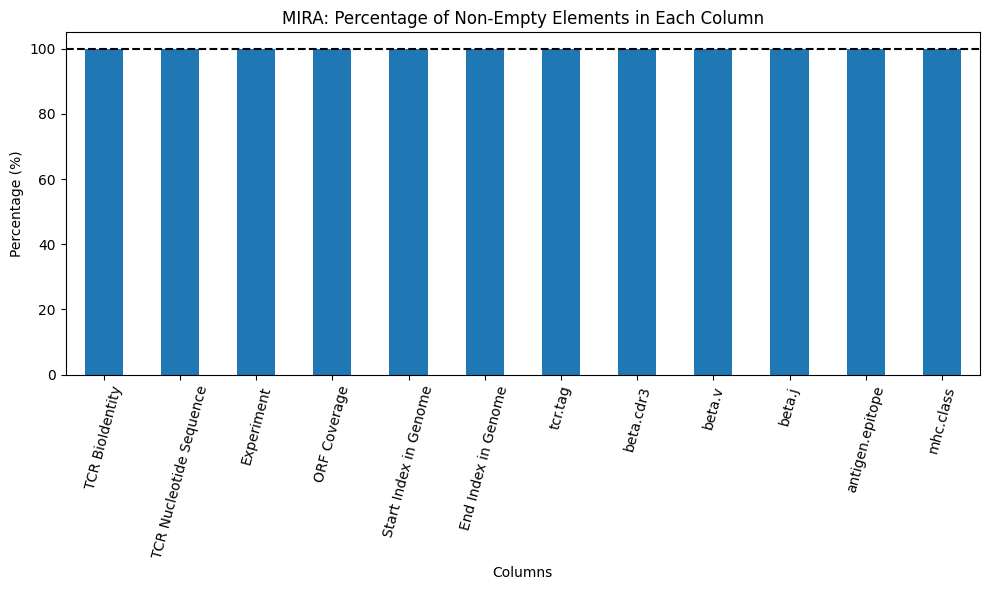

In [18]:
from utils import plot_non_empty_percentage

database = "MIRA"
plot_non_empty_percentage(final_df, database)